<a href="https://colab.research.google.com/github/BlueBlazin/nlp_from_ground_up/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow_datasets as tfds

First, some basic functions.

In [ ]:
def softmax(x):
    x -= np.max(x)
    x = np.exp(x)
    return x / np.sum(x)

In [ ]:
def cross_entropy(t, pred):
    target = np.zeros_like(pred)
    target[t] = 1
    return -np.sum(target * np.log(pred))

In [ ]:
def loss_fn(ts, ys):
    return sum(cross_entropy(t, y) for t, y in zip(ts, ys)) / len(ts)

The vanilla RNN is just $\mathbf{h_t} = \text{tanh}(\mathbf{W_x} \mathbf{x_t} + \mathbf{W_h} \mathbf{h_{t-1}} + \mathbf{b_h})$.

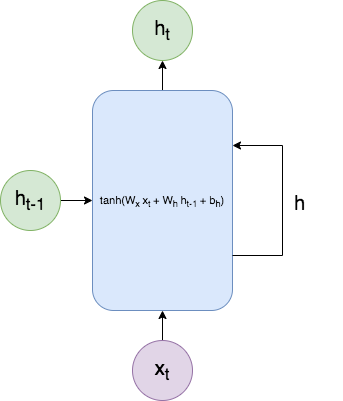

In [ ]:
def rnn_cell(x, hprev, Wx, Wh, bh):
    return np.tanh(Wx @ x + Wh @ hprev + bh)

In [ ]:
def forward_pass(xs, h, Wx, Wh, bh, Wy, by):
    hs = []
    ys = []

    for x in xs:
        h = rnn_cell(x, h, Wx, Wh, bh)
        hs.append(h)

        y = softmax(Wy @ h + by)
        ys.append(y)

    return ys, hs

#### Backward Pass

When it comes to writing backpropagation by hand it's helpful to be explicit by drawing the computation graph in steps of simple operations.

Note: If the emphasis is on simple operations, why the `cross_ent(softmax(r_t))` step? That's because that entire operation has a very simple gradient (explained below).

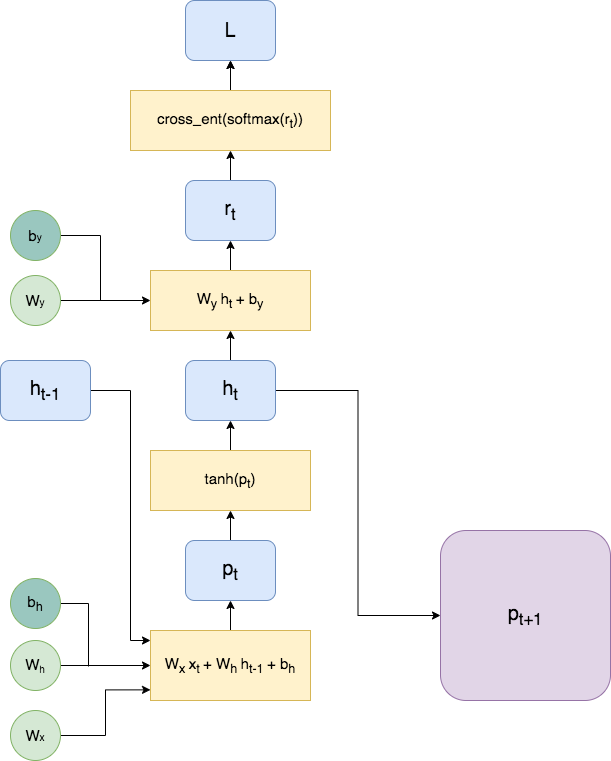

In [ ]:
def backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh):
    dWy = np.zeros_like(Wy)
    dby = np.zeros_like(by)

    dWx = np.zeros_like(Wx)

    dWh = np.zeros_like(Wh)
    dbh = np.zeros_like(bh)

    dpnext = np.zeros_like(hs[0])

    for t in reversed(range(len(ys))):
        y = ys[t]
        h = hs[t]
        x = xs[t]
        hprev = hs[t - 1]

        dr = y.copy()
        dr[ts[t]] -= 1

        dh = Wy.T @ dr + Wh @ dpnext

        dWy += dr @ h.T
        dby += dr

        dp = (1 - h * h) * dh

        dWx += dp @ x.T

        dWh += dp @ hprev.T
        dbh += dp

        dpnext = dp.copy()

    return dWy, dby, dWx, dWh, dbh

In [ ]:
xs = [np.array([[1, 0, 0, 0]]).T, np.array([[0, 1, 0, 0]]).T, np.array([[0, 0, 1, 0]]).T]

ts = [1, 2, 3]

Wx = np.random.randn(3, 4)

Wh = np.random.randn(3, 3)
bh = np.random.randn(3, 1)

Wy = np.random.randn(4, 3)
by = np.random.randn(4, 1)

hzero = np.zeros((3, 1))

In [ ]:
alpha = 0.01
losses = []

for i in range(5000):
    ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
    hs.append(hzero)

    losses.append(loss_fn(ts, ys))

    if i % 500 == 0:
        print(losses[-1])

    dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

    Wy -= alpha * dWy
    by -= alpha * dby

    Wx -= alpha * dWx

    Wh -= alpha * dWh
    bh -= alpha * dbh

2.3607984073364885
0.16584824092460781
0.04812708471639839
0.026364666031947277
0.01744332491300189
0.01268768775462673
0.00980834430634137
0.007921413041365233
0.006610148267592645
0.005655395741432642


In [ ]:
df = pd.DataFrame({'Epoch': range(len(losses)), 'Loss': losses})
fig = px.line(df, x="Epoch", y="Loss", title='Training loss')
fig.show()

In [ ]:
dataset = tfds.load(name='tiny_shakespeare')['train']

In [ ]:
def one_hot(k):
    enc = np.zeros((256, 1))
    enc[k, 0] = 1
    return enc

In [ ]:
hidden_dim = 64
vocab_size = 256
size = 25
alpha = 1e-2

In [ ]:
Wx = np.random.randn(hidden_dim, vocab_size)

Wh = np.random.randn(hidden_dim, hidden_dim)
bh = np.random.randn(hidden_dim, 1)

Wy = np.random.randn(vocab_size, hidden_dim)
by = np.random.randn(vocab_size, 1)

In [16]:
i = 0
losses = []

for record in dataset:
    line = list(record['text'].numpy())

    hzero = np.zeros_like(bh)

    for t in range(0, len(line) - size):
        ts = line[t:t + 25]
        xs = [one_hot(k) for k in ts]
        
        ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
        hs.append(hzero)

        losses.append(loss_fn(ts, ys))

        if i % 500 == 0:
            print(losses[-1])

        dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

        Wy -= alpha * dWy
        by -= alpha * dby

        Wx -= alpha * dWx

        Wh -= alpha * dWh
        bh -= alpha * dbh

        hzero = hs[-2]  # the last h_t will be the next hzero
        i += 1

Loss at step 1: 5.943931428182294
Loss at step 501: 2.9818119500035816
Loss at step 1001: 3.481655581948045
Loss at step 1501: 2.964450210769463
Loss at step 2001: 3.3294122388006953
Loss at step 2501: 2.866851584415497
Loss at step 3001: 3.264982578036151
Loss at step 3501: 2.974456510766824
Loss at step 4001: 3.086486454732859
Loss at step 4501: 3.8535403403753667
Loss at step 5001: 2.6224342903619218
Loss at step 5501: 3.1893118021253355
Loss at step 6001: 2.203424389747408
Loss at step 6501: 3.114797615300225
Loss at step 7001: 2.573306758224911
Loss at step 7501: 2.314365823838652
Loss at step 8001: 3.040587460786781
Loss at step 8501: 2.702673774362929
Loss at step 9001: 2.6539208944563253
Loss at step 9501: 2.6350534186129004
Loss at step 10001: 2.440694959771527
Loss at step 10501: 3.009080141470433
Loss at step 11001: 2.436504704651152
Loss at step 11501: 2.329469741754046
Loss at step 12001: 2.397909603505677
Loss at step 12501: 3.083720345167853
Loss at step 13001: 2.5376547